In [1]:
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch
from albumentations.pytorch.transforms import ToTensorV2
from capstone.data.datasets import get_miccai_2d
from capstone.transforms import predefined
from capstone.utils import miccai, visualize
from pytorch_lightning import seed_everything
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


%matplotlib inline

SEED = 5678

def visualize_batch(images, masks, structure=None):
    gray = False
    if images.shape[1] == 1:
        gray = True

    grid = make_grid(images).permute(1, 2, 0).numpy()
    if gray:
        grid = grid[:, :, [0]]
        
    if (structure is None) or (masks.shape[1] == 1):
        assert masks.shape[1] == 1, "Specify a structure to overlay"
        mask = masks[:, 0, :, :]
    else:
        idx = miccai.STRUCTURES.index(structure)
        mask = masks[:, idx, :, :]
    mask_grid = make_grid(mask.unsqueeze(1)).permute(1, 2, 0).numpy()[:, :, 0]

    fig, ax = plt.subplots(figsize=(16, 16))
    ax.imshow(grid, cmap=plt.cm.bone)
    ax.imshow(mask_grid, alpha=0.5)
    plt.show()

    return ax

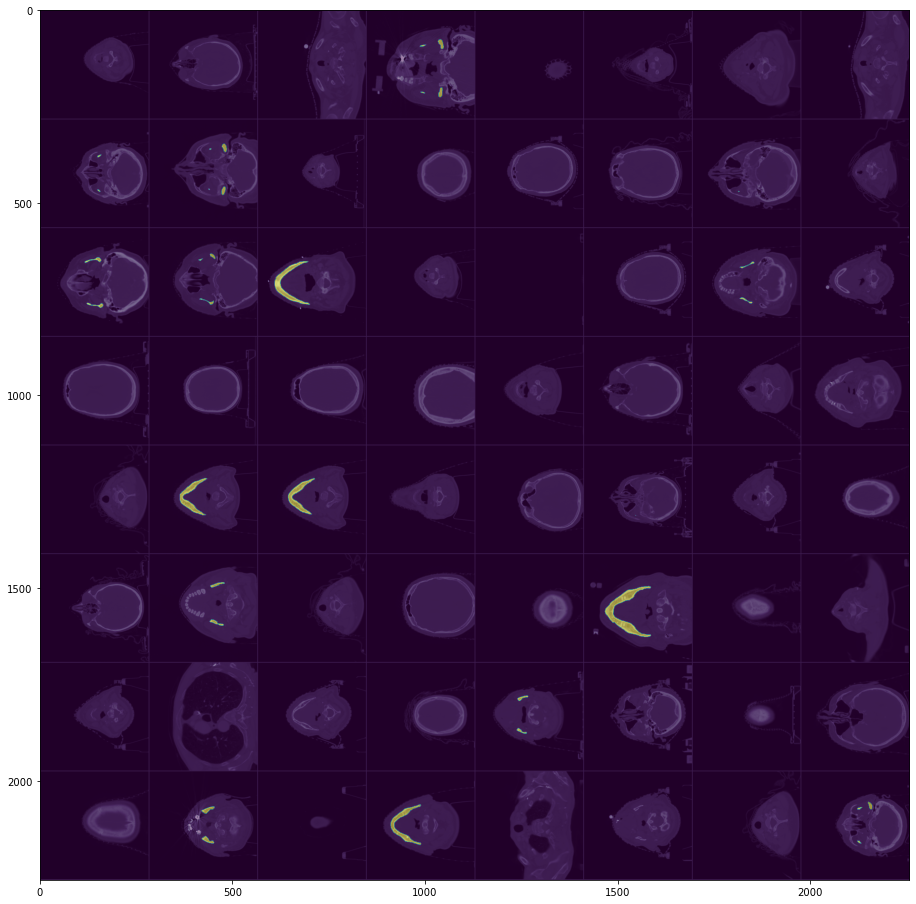

In [2]:
_ = seed_everything(SEED)
dataset = get_miccai_2d("train", transform=ToTensorV2())
loader = DataLoader(dataset, batch_size=64, shuffle=True)

sample_batch = iter(loader).__next__()
images, masks, mask_indicators = sample_batch

_ = visualize_batch(images, masks, structure="Mandible")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


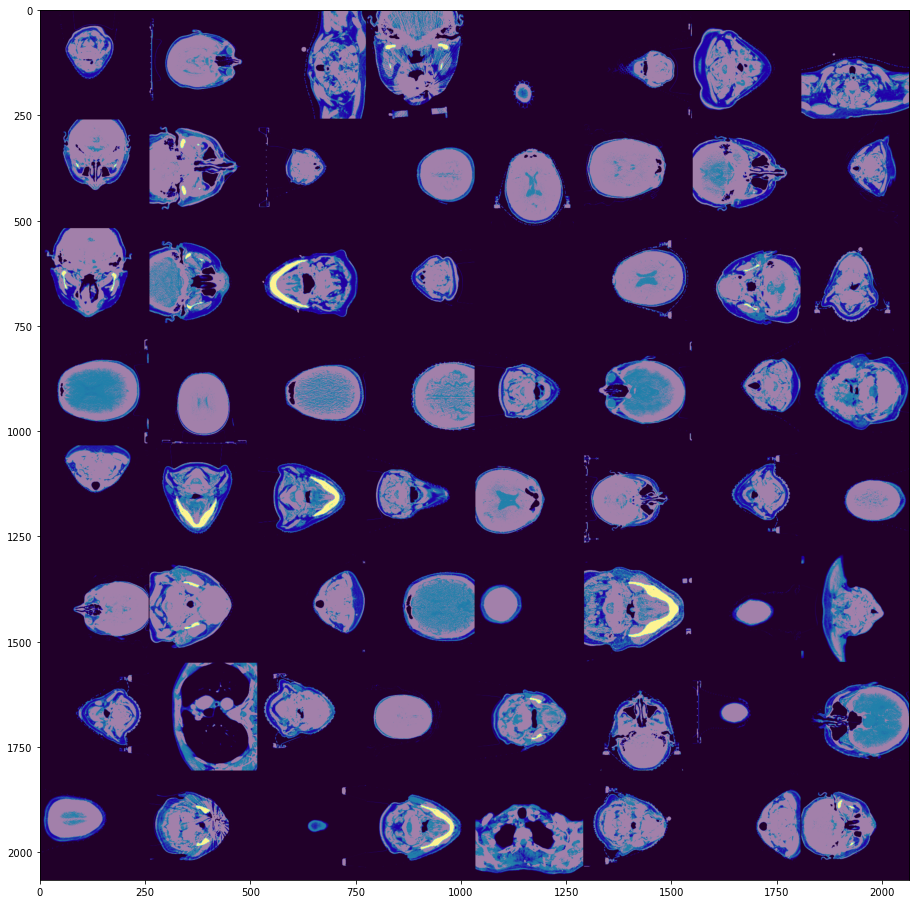

In [3]:
_ = seed_everything(SEED)
dataset = get_miccai_2d(
    "train",
    structure="Mandible",
    transform=predefined.minimal_windowed_transforms(),
)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

sample_batch = iter(loader).__next__()
images, masks, mask_indicators = sample_batch

_ = visualize_batch(images, masks)
plt.show()